# Reproducibility with original data

This tutorial demonstrates how to identify spatial domains on 10x Visium data using SODB and STAGATE based on pyG (PyTorch Geometric) framework.

A reference paper can be found at https://www.nature.com/articles/s41467-022-29439-6.

This tutorial refers to the following tutorial at https://stagate.readthedocs.io/en/latest/T1_DLPFC.html. At the same time, the way of loadding data is modified by using SODB.

## Import packages and set configurations

In [1]:
# Use the Python warnings module to filter and ignore any warnings that may occur in the program after this point.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import several Python packages commonly used in data analysis and visualization:
# pandas (imported as pd) is a package for data manipulation and analysis
import pandas as pd
# numpy (imported as np) is a package for numerical computing with arrays
import numpy as np
# scanpy (imported as sc) is a package for single-cell RNA sequencing analysis
import scanpy as sc
# matplotlib.pyplot (imported as plt) is a package for data visualization
import matplotlib.pyplot as plt
# os is a package for interacting with the operating system, such as reading or writing files
import os
# sys is a package for interacting with the Python interpreter
import sys

In [3]:
# Import the adjusted_rand_score function from the sklearn.metrics.cluster module of the scikit-learn library. 
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
# Import STAGATE_pyG package
import STAGATE_pyG

In [5]:
# The location of R (used for the mclust clustering)
# os.environ['R_HOME'] = '/home/<usr_name>/anaconda3/envs/<environment_name>/lib/R/'
# os.environ['R_USER'] = '/home/<usr_name>/anaconda3/envs/<environment_name>/lib/R/rpy2'
os.environ['R_HOME'] = '/home/linsenlin/anaconda3/envs/stagate38/lib/R/'
os.environ['R_USER'] = '/home/linsenlin/anaconda3/envs/stagate38/lib/R/rpy2'

## Streamline development of loading spatial data with SOBD

In [7]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [ ]:
# Initialization
sodb = pysodb.SODB()

In [8]:
# Define names of the dataset_name and experiment_name
dataset_name = 'maynard2021trans'
experiment_name = '151676'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata = sodb.load_experiment(dataset_name,experiment_name)

download experiment[151676] in dataset[maynard2021trans]


100%|██████████| 121M/121M [01:03<00:00, 2.00MB/s] 


load experiment[151676] in dataset[maynard2021trans]


In [9]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

# Data processing

In [10]:
# Make the index unique by appending a number string to each duplicate index element
adata.var_names_make_unique()

In [11]:
# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [12]:
# Read the annotation
Ann_df = pd.read_csv('/home/linsenlin/protocols/sc/stagate/STAGATE_pyG/data/151676_truth.txt', sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [15]:
# Add a ['Ground Truth'] column from the 'Ground Truth' column in the 'Ann_df'.
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

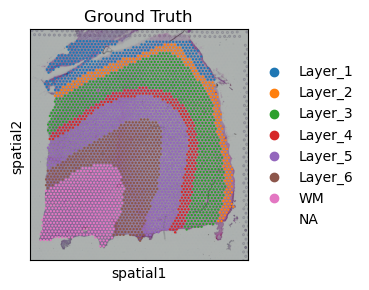

In [17]:
# Generate a spatial plot using the image specified in the 'hires' key and coloring the plot based on the 'Ground Truth' column.
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=['Ground Truth'])

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


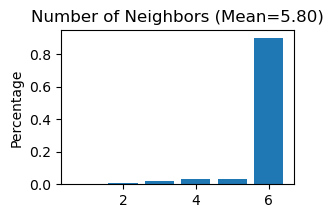

In [18]:
# Use "STAGATE_pyG.Cal_Spatial_Net" to calculate a spatial graph with a radius cutoff of 150.
STAGATE_pyG.Cal_Spatial_Net(adata, rad_cutoff=150)
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information.
STAGATE_pyG.Stats_Spatial_Net(adata)

## Running STAGATE

In [19]:
# Train a STAGATE model 
adata = STAGATE_pyG.train_STAGATE(adata)

Size of Input:  (3460, 3000)


100%|██████████| 1000/1000 [00:06<00:00, 144.71it/s]


## Spatial Clustering

In [ ]:
# Calculate the nearest neighbors in the 'STAGATE' representation and computes the UMAP embedding.
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [20]:
# Use Mclust_R to cluster cells in the 'STAGATE' representation into 7 clusters.
adata = STAGATE_pyG.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [21]:
# Compute the adjusted rand index (ARI) between the 'mclust' and the 'Ground Truth'. 
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.60


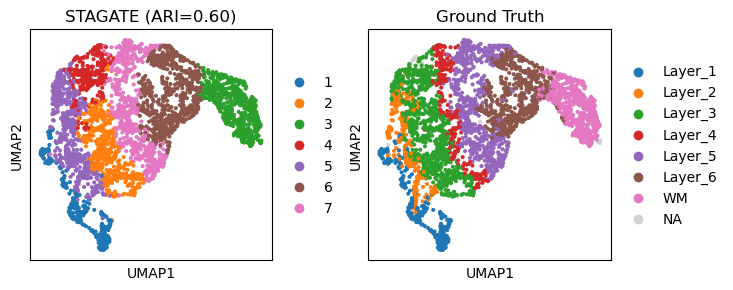

In [22]:
# Generate a plot of the UMAP embedding colored by both a mclust and a ground truth.
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

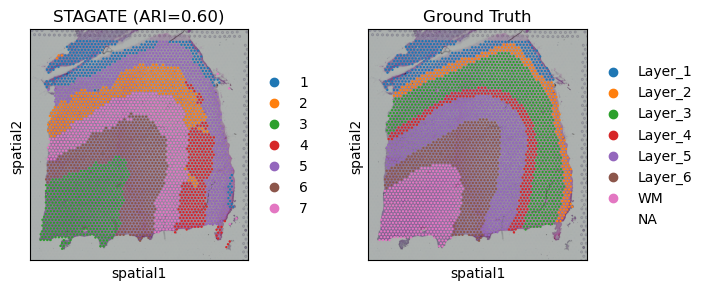

In [23]:
# Visualize the result using mclust and Ground Truth.
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

## Spatial trajectory inference (PAGA)

In [24]:
"""
used_adata = adata[adata.obs['Ground Truth']!='nan']
used_adata
"""

"\nused_adata = adata[adata.obs['Ground Truth']!='nan']\nused_adata\n"

In [25]:
# Exclude any cells with missing values in the 'Ground Truth' column of the observation metadata.
used_adata = adata[pd.notna(adata.obs['Ground Truth'])]
used_adata

View of AnnData object with n_obs × n_vars = 3431 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'leiden', 'Ground Truth', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap', 'Ground Truth_colors', 'Spatial_Net', 'mclust_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'STAGATE'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [26]:
# Use PAGA to infer differentiation trajectories.
sc.tl.paga(used_adata, groups="Ground Truth")

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

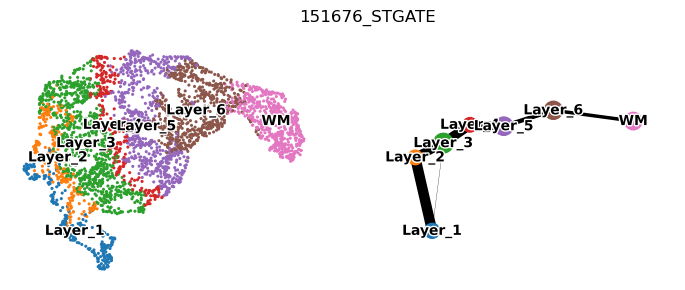

In [27]:
# Compare partition-based graph abstraction (PAGA) results.
plt.rcParams["figure.figsize"] = (4,3)
sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20,
                   title=experiment_name+'_STGATE', legend_fontoutline=2, show=False)